In [3]:
import codecs
import re
import os

In [62]:
# modified from https://segmentfault.com/q/1010000000732038
# to detect english character and hyphen ONLY
def isAlphahyphen(word):
    try:
        float(word)
        return True
    except:
        if word == '-':
            return True
        elif word == "'":
            return True
        elif word == ".":
            return True
        else:
            try:
                return word.replace('-','').replace("'",'').replace(".",'').encode('ascii').isalnum()
            except UnicodeEncodeError:
                if word == '-':
                    return True
                else:
                    return False
    
# copied from http://www.cnblogs.com/kaituorensheng/p/3554571.html
# -*- coding: cp936 -*-
def strQ2B(ustring):
    """全角转半角"""
    rstring = ""
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288:                              #全角空格直接转换            
            inside_code = 32 
        elif (inside_code >= 65281 and inside_code <= 65374): #全角字符（除空格）根据关系转化
            inside_code -= 65248

        rstring += chr(inside_code)
    return rstring

In [63]:
def splitMix(word):
    res = []
    idx_b = 0
    for i in range(len(word)):
        if i == 0:
            char_b = isAlphahyphen(word[i])
        else:
            if char_b == isAlphahyphen(word[i]):
                next
            else:
                char_b = isAlphahyphen(word[i])
                res += [word[idx_b:i]]
                idx_b = i
    res += [word[idx_b:]]
    return res

In [65]:
splitMix('中文ns.23')

['中文', 'ns.23']

In [7]:
filename_cmu = "cmudict-0.7b"

d_cmu = dict()
max_num = 0 # max number of (x) <-- a word with multiple pronunciations
f = open(filename_cmu,"r")
for line in f.readlines():
    if line[0:3] != ";;;":
        line = line[:-1]
        line = line.split("  ",1)
        d_cmu[line[0]] = line[1]
        if line[0][-1] == ")":
            try: 
                num_cur = int(line[0][-2])      
                if int(line[0][-2]) > max_num:
                    max_num = num_cur
            except:
                continue

print("Finish loading cmu dictionary")
print("Number of English lexicon: " + str(len(d_cmu)))

Finish loading cmu dictionary
Number of English lexicon: 133854


In [8]:
filename_th = "thchs30-lexicon.txt"

d_th = dict()
with codecs.open(filename_th, 'r', 'utf-8') as f:
    for line in f.readlines():
        line = line.split()
        d_th[line[0]] = ' '.join(line[1:])
print("Finish loading thchs30 dictionary")
print("Number of Chinese lexicon: " + str(len(d_th)))

Finish loading thchs30 dictionary
Number of Chinese lexicon: 8873


In [9]:
# the length of thchs30-lexiconp.txt is the same to thchs30-lexicon.txt
# and the content looks same..
'''
filename_thp = "thchs30-lexiconp.txt"

d_thp = dict()
max_num = 0
#f = open(filename_th,"r")
with codecs.open(filename_th, 'r', 'utf-8') as f:
    for line in f.readlines():
        line = line.split()
        d_thp[line[0]] = ' '.join(line[1:])
print(len(d_thp))
print("Finish loading thchs30 dictionary p")
'''

'\nfilename_thp = "thchs30-lexiconp.txt"\n\nd_thp = dict()\nmax_num = 0\n#f = open(filename_th,"r")\nwith codecs.open(filename_th, \'r\', \'utf-8\') as f:\n    for line in f.readlines():\n        line = line.split()\n        d_thp[line[0]] = \' \'.join(line[1:])\nprint(len(d_thp))\nprint("Finish loading thchs30 dictionary p")\n'

In [28]:
dir = "./transcript"

# to get the full word list
filenames = os.listdir(dir)
words = []
for filename in filenames:
    if filename[-4:] == ".txt":
        with codecs.open(dir+"/"+filename, 'r', 'utf-8') as f:
            for line in f.readlines():
                sentence = line.split() # 1st element -- audio file id, 2nd element -- start time, 3rd element -- end time
                words_cur = sentence[3:]
                words += words_cur
            f.close()

print("Finish concatenating words")
print("Number of words: " + str(len(words)))
print("Number of unique words: " + str(len(set(words))))

Finish concatenating words
Number of words: 573401
Number of unique words: 35962


In [29]:
# create a dictionary of waste words
words_waste = []
words_1 = [] # [x]
words_2 = [] # (x)
        
for word in words:
    if word[-1] == "]" or word[0] == "[":
        word = re.findall(r'''(\[.+?\])''',word)
        words_1 += word
    elif word[-1] == ")" or word[0] == "(":
        word = re.findall(r'''(\(.+?\))''',word)
        words_2 += word
        
words_waste = words_1 + words_2

d_waste = dict()
for word in words_waste:
    try:
        d_waste[word] += 1
    except:
        d_waste[word] = 1

d_waste2idx = dict()
idx = -1
for k in d_waste.keys():
    idx += 1
    d_waste2idx[k] = 'SIL' + str(idx)

d_idx2waste = {v:k for k,v in d_waste2idx.items()}

print("Finish creating waste word dictionary")
print("Number of waste word type: " + str(len(set(words_waste))))

Finish creating waste word dictionary
Number of waste word type: 187


In [67]:
# fix and output the transcript text going to be used
dir = "./transcript/"
dir_save = "./transcript_fixed/" 
filenames = os.listdir(dir)
words_all = []
text_all = []
text_unparse = []
for filename in filenames:
    if filename[-4:] == ".txt":
        with codecs.open(dir+filename, 'r', 'utf-8') as f:
            text = []

            for line in f.readlines():

                sentence_origin = line.strip()            
                
                words_mm_cur = set(re.findall(r'''o(\[.+?\])''',line))
                if len(words_mm_cur) > 0:
                    sentence_origin = sentence_origin.replace('o[mm]','omm')
                
                # replace waste words with SILx
                words_waste_cur = set(re.findall(r'''(\[.+?\])''',line) + re.findall(r'''(\(.+?\))''',line))
                for element in words_waste_cur:
                    try:
                        sentence_origin = sentence_origin.replace(element,' ' + d_waste2idx[element] + ' ')
                    except:
                        continue
                                
                # get rid of "#"
                # get rid of "="
                # deal with %word% like %chelsia%
                # deal with "word" like "william"
                # cancel: deal with pronunciation of single letter, for which the trascript is like P. S., I. T., etc. --> P. is how cmu dictionary documents it
                # deal with x.y. like u.s.
                # deal with [ chinese char ] like [ 啊 ]
                sentence_origin = sentence_origin.replace('#',' ').replace('=',' ').replace('%',' ').replace('"',' ').replace(' .',' ').replace('.','. ').replace('[',' ').replace(']',' ')
                

                    
                # trim multiple space within the sentence
                sentence_origin = " ".join(sentence_origin.split())
                
                # Q2B
                sentence_chars = list(sentence_origin)
                for char_idx in range(len(sentence_chars)):
                    sentence_chars[char_idx] = strQ2B(sentence_chars[char_idx])
                sentence_origin = "".join(sentence_chars)
                
                #length_origin = len(sentence_origin)
                #sentence_backup = sentence_origin

                words_fix = []
                info_cur = sentence_origin.split()[:3]
                words_cur = sentence_origin.split()[3:]
                
                for word_cur in words_cur:
                    word_cur = splitMix(word_cur)
                    if isinstance(word_cur,list):
                        words_fix += word_cur
                    else:
                        words_fix += [word_cur]                
                sentence_origin = " ".join(info_cur+words_fix)
                
                #if '.' in sentence_origin:
                #    print(sentence_origin)
                    
                #if length_origin != len(sentence_origin):
                #    print(str(sentence_backup)+" / " + str(sentence_origin))

                
                # trim again incase the substitution brings in space
                sentence_origin = sentence_origin.strip()
                              
                sentence = sentence_origin.split() # 1st element -- audio file id, 2nd element -- start time, 3rd element -- end time
                info_cur = sentence[:3] # idx: 0~2
                words_cur = sentence[3:] # idx: 3~
                unparse = False
    
                for word in words_cur: # filter out concatenated characters having Chinese characters, with length over 4
          
                    # filter out unsegmented element (unparse = F -> unparse = T)
                    # for example, [leh]每次上学的时候daddy都会买糕点给我吃买马来糕#kuih# (idx: 53628)
                    if not isAlphahyphen(word): 
                        try:
                            d_th[word] # if the word is a recorded Chinese word
                            continue
                        except:
                            if len(word) > 4:
                                unparse = True
                                break
    
                if unparse:
                    text_unparse += [sentence_origin]
                else:
                    words_cur_fix = []
                    for word_cur in words_cur:
                        word_cur = word_cur.upper()
                        if not isAlphahyphen(word_cur): # if is not a english word
                            try:
                                d_th[word_cur]
                                words_cur_fix += [word_cur]
                            except:
                                if len(word_cur)>1: # if length of word > 1, or more than 1 chinese character
                                    needtosplit = True
                                    for char_idx in range(len(word_cur)):
                                        words_cur_fix += word_cur[char_idx]
                                else: # if only has one chinese character
                                    words_cur_fix += [word_cur]
                        else: # if is not chinese word
                            words_cur_fix += [word_cur]

                    if len(words_cur_fix) > 0:
                        sentence_cur = " ".join(info_cur) + " " + " ".join(words_cur_fix)
                        text += [sentence_cur]
                        text_all += [sentence_cur]
                        words_all += words_cur_fix
                        if "A" in words_cur_fix:
                            print(sentence_cur)
    
            f.close()
            
        #save files without unparsed lines
        with codecs.open(dir_save+filename, 'w', 'utf-8') as f:
            for line in text:
                f.write(line + "\n")
        f.close()

with codecs.open(dir_save+'unparsed.txt', 'w', 'utf-8') as f:
    for line in text_unparse:
        f.write(line + "\n")
    f.close()

with codecs.open(dir_save+'text.txt', 'w', 'utf-8') as f:
    for line in text_all:
        f.write(line + "\n")
    f.close()
            
print("Finish propocessing lines")
print("Number of segmented utterance: "+str(len(text_all)))
print("Number of unsegmented utterance: "+str(len(text_unparse)))

01NC01FBX_0101 1036230 1045850 他 是 FROM ENGINE 的 THEN 他 就 就 也是 A LEVELS 考 得 很 烂 很 烂 THEN 就 被 丢 进 ENGINE BUT THEN 他 YEAR ONE SEM ONE 就 考 得 LIKE THREE POINT SOMETHING 就 NOT BAD THEN 他 就 APPLY THEN 就 换
01NC01FBX_0101 1106560 1115600 因为 我 的 FIRST CHOICE 我 放 ACCOUNTANCY SECOND CHOICE 我 才 放 ECONS THEN 我 就 没有 进 ACCOUNTANCY 因为 那时 候 那个 CUTOFF 是 A A B. S. 我 不是 蛮 高 的 我 就 拿 B. B. B. 那种
01NC01FBX_0101 1124910 1131600 就 我 觉得 THREE YEARS THEN SOME MORE 它 是 一个 PROFESSIONAL JOB THEN 我 就 觉得 I MEAN LIKE WHY SPEND FOUR YEARS DOING A GENERAL ARTS
01NC01FBX_0101 1470440 1480000 从 我 一 到 那个 TOA-PAYOH M. R. T. STATION 我 就 看 很多 人 惨 了 那个 ANNOUNCEMENT 就 讲 THERE WAS SOME DELAY IN THE PREVIOUS TRAIN THEN 就 什么 IT MIGHT CAUSE IT MIGHT CAUSE A 什么 DELAY IN YOUR RIDE 什么 东 西
01NC01FBX_0101 1898810 1906880 AND THEN 他 就 PAY 了 LIKE ALMOST SIXTY SIX HUNDRED THOUSAND FOR 那个 屋子 就 MORE THAN HALF OF A MILLION FOR 一个 新的 H. D. B. FLAT LEH
01NC02FBY_0101 429450 432130 的 那 本 书 CAUSE I WAS SAYING SOMETHING ABOUT A
01NC02FBY_0101 9558

In [31]:
# test
'''
sentence_origin = "x0021 453 643 ."
sentence_origin = sentence_origin.strip()            
                
words_mm_cur = set(re.findall(r'''o(\[.+?\])''',line))
if len(words_mm_cur) > 0:
    sentence_origin = sentence_origin.replace('o[mm]','omm')
# replace waste words with SILx
words_waste_cur = set(re.findall(r'''(\[.+?\])''',line) + re.findall(r'''(\(.+?\))''',line))
for element in words_waste_cur:
    try:
        sentence_origin = sentence_origin.replace(element,' ' + d_waste2idx[element] + ' ')
    except:
        continue

sentence_origin = sentence_origin.replace('#',' ').replace('=',' ').replace('%',' ').replace('"',' ').replace('.',' ').replace('[',' ').replace(']',' ')
                
# trim multiple space within the sentence
sentence_origin = " ".join(sentence_origin.split())
                
                # Q2B
sentence_chars = list(sentence_origin)
for char_idx in range(len(sentence_chars)):
    sentence_chars[char_idx] = strQ2B(sentence_chars[char_idx])
sentence_origin = "".join(sentence_chars)
    
words_fix = []
info_cur = sentence_origin.split()[:3]
words_cur = sentence_origin.split()[3:]
                
for word_cur in words_cur:
    word_cur = splitMix(word_cur)
    if isinstance(word_cur,list):
        words_fix += word_cur
    else:
        words_fix += [word_cur]                
sentence_origin = " ".join(info_cur+words_fix)

sentence_origin = sentence_origin.strip()
                              
sentence = sentence_origin.split() # 1st element -- audio file id, 2nd element -- start time, 3rd element -- end time
info_cur = sentence[:3] # idx: 0~2
words_cur = sentence[3:] # idx: 3~
unparse = False

for word in words_cur: # filter out concatenated characters having Chinese characters, with length over 4
          
                    # filter out unsegmented element (unparse = F -> unparse = T)
                    # for example, [leh]每次上学的时候daddy都会买糕点给我吃买马来糕#kuih# (idx: 53628)
    if not isAlphahyphen(word): 
        try:
            d_th[word] # if the word is a recorded Chinese word
            continue
        except:
            if len(word) > 4:
                unparse = True
                break

words_cur_fix = []
for word_cur in words_cur:
    word_cur = word_cur.upper()
    if not isAlphahyphen(word_cur): # if is not a english word
        try:
            d_th[word_cur]
            words_cur_fix += [word_cur]
        except:
            if len(word_cur)>1:
                needtosplit = True
                for char_idx in range(len(word_cur)):
                    words_cur_fix += word_cur[char_idx] 
            else:
                words_cur_fix += [word_cur]
    else:
        words_cur_fix += [word_cur]

if len(words_cur_fix) > 0:
    print(sentence_origin)
    print(words_cur_fix)
'''

SyntaxError: invalid syntax (<ipython-input-31-fac4d4fa331b>, line 6)

In [32]:
d_waste

{'(ppb)': 14,
 '(ppc)': 5,
 '(ppl)': 223,
 '(ppo)': 48,
 '[EHEM]': 1,
 '[MMM]': 1,
 '[ORH]': 1,
 '[a]': 5,
 '[afri]': 1,
 '[ah-nah]': 1,
 '[ah-nor]': 1,
 '[ah]': 2137,
 '[ahem]': 5,
 '[ahh]': 4,
 '[ahm]': 1,
 '[ai]': 2,
 '[aik]': 1,
 '[aiya]': 8,
 '[aiyah]': 9,
 '[aiyoh]': 1,
 '[an]': 1,
 '[app]': 1,
 '[ar]': 45,
 '[arr]': 146,
 '[ayer]': 1,
 '[bip]': 3,
 '[blah]': 6,
 '[boh]': 2,
 '[chap]': 1,
 '[che]': 8,
 '[chine]': 1,
 '[chiup]': 3,
 '[chom]': 1,
 '[chu]': 3,
 '[competi]': 1,
 '[confi]': 1,
 '[cul]': 1,
 '[de]': 6,
 '[dedede]': 1,
 '[deng]': 3,
 '[di]': 1,
 '[dup]': 1,
 '[dy]': 1,
 '[eh]': 397,
 '[ei]': 51,
 '[elec]': 1,
 '[em]': 47,
 '[emm]': 135,
 '[en]': 2,
 '[eng]': 1,
 '[er]': 789,
 '[erm]': 653,
 '[err]': 359,
 '[fin]': 1,
 '[fu]': 1,
 '[ga]': 1,
 '[gar]': 2,
 '[gen]': 1,
 '[gi]': 1,
 '[goh]': 1,
 '[goo]': 1,
 '[gra]': 1,
 '[ha]': 184,
 '[hah]': 3,
 '[haha]': 1,
 '[hahaha]': 1,
 '[hai]': 8,
 '[haiya]': 1,
 '[har]': 69,
 '[harr]': 3,
 '[he]': 7,
 '[heh]': 1,
 '[hehe]': 1,
 '[h

In [58]:
for k,v in d_waste.items():
    try:
        print(str(k[1:-1].upper())+": "+str(d_cmu[k[1:-1].upper()]))
    except:
        continue

GEN: JH EH1 N
O: OW1
YAM: Y AE1 M
WOW: W AW1
LO: L OW1
MO: M OW1
DENG: D EH1 NG
HAH: HH AA1
UH-HUH: AH1 HH AH1
HUH: HH AH1
ERR: EH1 R
PIT: P IH1 T
STA: S T AH1
UM: AH1 M
PANG: P AE1 NG
WA: W AA1
LI: L IY1
OI: OY1
PORT: P AO1 R T
GA: G AA1
BLAH: B L AA1
NOR: N AO1 R
MANA: M AA1 N AH0
OHH: OW1
LOR: L AO1 R
EM: EH1 M
APP: AE1 P
PUN: P AH1 N
HO: HH OW1
WHOA: W OW1
YA: Y AA1
AN: AE1 N
LIL: L IH1 L
MI: M IY1
ENG: EH1 NG
SIL: S IH1 L
LANG: L AE1 NG
SI: S IY1
HE: HH IY1
SOM: S AA1 M
MINO: M IY1 N OW0
PAK: P AE1 K
POP: P AA1 P
HAR: HH AA1 R
MA: M AA1
BIP: B IH1 P
CHU: CH UW1
CHE: CH EY1
NAH: N AA1
MOTI: M OW1 T IY0
HEH: HH EH1
LIAO: L IY0 AW1
DE: D IY1
YEAR: Y IH1 R
RAK: R AE1 K
PHAR: F AA1 R
MAI: M AY1
CHAP: CH AE1 P
LAR: L AA1 R
GOH: G OW1
AI: AY1
OH: OW1
PI: P AY1
KI: K IY1
S: EH1 S
NI: N IY1
LEH: L EH1
FU: F UW1
HORR: HH AO1 R
KU: K UW1
OP: AA1 P
GOO: G UW1
WAH: W AA1
STU: S T UW1
EN: EH1 N
U: Y UW1
YI: Y IY1
DI: D IY1
WO: W OW1
ORR: AO1 R
HMM: HH AH0 M
CUL: K AH1 L
YAY: Y EY1
AR: AA1 R
WOR

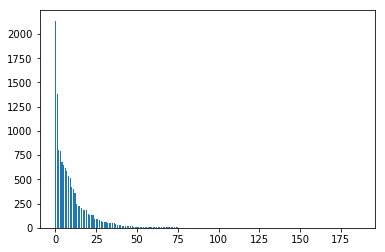

In [33]:
import matplotlib.pyplot as plt
plt.bar(range(len(d_waste)),sorted([v for v in d_waste.values()],reverse=True),width=1/1.5)
plt.show()

In [ ]:
d_cmu['sherpy']

In [68]:
# output silence_phones.txt
with codecs.open(dir_save+'silence_phones.txt', 'w', 'utf-8') as f:
    f.write('SIL\n')
    for k,v in d_waste2idx.items():
        f.write(v + "\n")
f.close()
print("Finish writing silence_phones.txt")

# output nonsilence_phones.txt
phones = []

with codecs.open('cmudict-0.7b.phones', 'r', 'utf-8') as f:
    for phone in f.readlines():
        phone = phone.split()
        phones += [phone[0]]
f.close()

with codecs.open('thchs30-nonsilence_phones.txt', 'r', 'utf-8') as f:
    for phone in f.readlines():
        phones += [phone[:-1]] #negelect \n
f.close()

with codecs.open(dir_save+'nonsilence_phones.txt', 'w', 'utf-8') as f:
    for phone in phones:
        f.write(phone + "\n")
f.close()

print("Finish writing nonsilence_phones.txt")
#print(phones)

Finish writing silence_phones.txt
Finish writing nonsilence_phones.txt


In [69]:
words_all = [word.upper() for word in words_all]
words_all_uniq = list(set(words_all))
words_oov = []
d_train = dict()

word_in_cmu = []
word_in_th = []
word_oov_english = []
word_oov_other = []
for word in words_all_uniq:
    try:
        d_train[word] = d_cmu[word]
        word_in_cmu += [word]
        for i in range(1,max_num+1):
            try:
                d_train[word+"(i)"] = d_cmu[word+"(i)"]
            except:
                break
    except:
        try:
            d_train[word] = d_th[word]
            word_in_th += [word]
        except:
            try:
                d_idx2waste[word]
            except:
                if isAlphahyphen(word):
                    word_oov_english += [word]
                else:
                    word_oov_other += [word]
            
                words_oov += [word]
                continue

print("Finish lexicon filtering")
print("Number of words used: " + str(len(words_all)))
print("Number of unique words used: " + str(len(words_all_uniq)))
print("Number of unique words in filtered lexicon file: " + str(len(d_train)))
print("")
print("Number of English word in lexicon: " + str(len(word_in_cmu)))
print("Number of English word not in lexicon: " + str(len(word_oov_english)))
print("Number of Chinese word in lexicon: " + str(len(word_in_th)))
print("Number of Chinese word not in lexicon: " + str(len(word_oov_other)))

Finish lexicon filtering
Number of words used: 591580
Number of unique words used: 13877
Number of unique words in filtered lexicon file: 11539

Number of English word in lexicon: 8606
Number of English word not in lexicon: 1336
Number of Chinese word in lexicon: 2933
Number of Chinese word not in lexicon: 871


In [70]:
word_oov_english

['TENTANG',
 'CANIDAE',
 'SNORKELLING',
 'BACKSTREET',
 'GORGOR',
 'DIO',
 'LASSI',
 'CERVIC',
 'POKEMON',
 'SPECIALISED',
 'RENALD',
 'ANG-POW',
 'KASPERSKY',
 'MAUIS',
 'TASIK',
 'JURONG-JUNIOR-COLLEGE',
 'VAIBILITY',
 'YONEX',
 'BLOGSPOT',
 'MING-XIU',
 'TRANSEX',
 'STPM',
 'HERBALLIFE',
 'CUSTOMIZATION',
 'HEXIS',
 'JALAN',
 'BIZ-MAG',
 'CATEGORISE',
 '1',
 'HANA-KIMI',
 'AIYAH',
 'AIYA',
 'DURIAN',
 'XIN-YI',
 'IHG',
 'COLOURFUL',
 'COSPLAY',
 'NESCAFE',
 'GRANUE',
 'POLYTECHNICS',
 'UNIS',
 'HOKKIEN',
 'MAI-HUM',
 'SYCHOLOGY',
 'ROSTED',
 'ZAI',
 'SQUEEZY',
 'TEMASEK',
 'FROSTER',
 'AO',
 'BACTERIAS',
 'RE-SUSTAINABLE',
 'BUNGEE-JUMPING',
 'RECORDIST',
 'COURSEMATE',
 'HONOURS',
 'YAKULT',
 'PENMANSHIP',
 'GEK',
 'SAIKANG',
 'SUA',
 'JUN-FENG',
 'STRUC',
 'INTENATIONAL',
 'OOI-SIEW-MIAN',
 'MUAY-THAI',
 'SENTOSA',
 'ZHI-RUI',
 'PULA',
 'PAYA-LEBAR',
 'SOO-KEE',
 'E-STEP',
 'YAN-QING',
 'HUI-FOON',
 'BARISTAR',
 'LOGIN',
 'NEW-YORK',
 'KIASU',
 'RAJA',
 'SHI-LING',
 'VIBRIOS',
 'P

In [71]:
d_words = dict()
for word in words_all:
    try:
        d_words[word] += 1
    except:
        d_words[word] = 1

plot_x = range(len(d_words))
plot_y = sorted([v for v in d_words.values()],reverse=True)
d_top = {k:v for k,v in d_words.items() if v in plot_y[0:50]}
for k,v in d_top.items():
    print(str(k)+": "+str(v))

那: 2373
THE: 4367
不: 3560
ER: 2400
I: 4992
了: 3987
是: 10175
AH: 2153
他们: 3763
我们: 4378
THAT: 2188
因为: 4036
然后: 3329
TO: 3402
就: 7853
有: 6520
没有: 3758
你: 8743
所以: 2357
BUT: 2844
一个: 2445
很: 5580
啊: 7836
东: 2036
会: 3892
他: 8433
IN: 2055
的: 20823
THEN: 7614
跟: 2120
对: 1929
要: 4412
去: 5186
在: 3529
SO: 2646
啦: 3323
就是: 3372
做: 2527
那个: 5306
LIKE: 4166
讲: 3429
西: 2028
IS: 1950
我: 16403
一: 2476
好像: 2150
到: 2310
人: 2225
这样: 2928
YOU: 2801


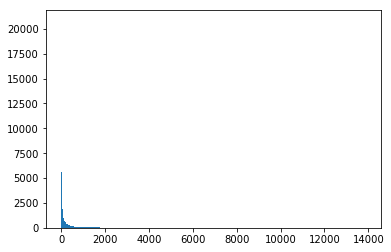

In [72]:
plt.bar(plot_x,plot_y,width=1)
plt.show()

In [73]:
# output lexicon.txt
lexicons = [str(k) + " " + str(v) + "\n" for k,v in d_train.items()]

with codecs.open(dir_save+'lexicon.txt', 'w', 'utf-8') as f:
    f.write('<oov> <oov>\n')
    for lexicon in lexicons:
        print(lexicon)
        f.write(lexicon)
    #for word in words_oov:
    #    f.write(str(word) + " " + "<oov>\n")
    for k,v in d_waste2idx.items():
        print(v + " sil" + "\n")
        f.write(v + " sil" + "\n")
        
f.close()

print("Finish writing lexicon.txt")

CARDS K AA1 R D Z

医治 ii i1 zh ix4

ARCHITECT AA1 R K AH0 T EH2 K T

SHIRT SH ER1 T

SLIGHTLY S L AY1 T L IY0

SIDETRACK S AY1 D T R AE2 K

TIMELINE T AY1 M L AY0 N

INJECTION IH2 N JH EH1 K SH AH0 N

座 z uo4

TOOK T UH1 K

INDIANA IH2 N D IY0 AE1 N AH0

WEDGE W EH1 JH

SAXOPHONE S AE1 K S AH0 F OW2 N

STRAWBERRY S T R AO1 B EH2 R IY0

JULIA JH UW1 L Y AH0

GOOGLING G UW1 G L IH0 NG

REPLACEMENT R IH0 P L EY1 S M AH0 N T

SPECIAL S P EH1 SH AH0 L

大会 d a4 h ui4

GROUPINGS G R UW1 P IH0 NG Z

LANDED L AE1 N D AH0 D

FISCAL F IH1 S K AH0 L

CHECKUP CH EH1 K AH2 P

集 j i2

EQUIVALENT IH0 K W IH1 V AH0 L AH0 N T

HANDS HH AE1 N D Z

YOGURT Y OW1 G ER0 T

DISHES D IH1 SH AH0 Z

CDS S IY1 D IY1 Z

PRESSURE P R EH1 SH ER0

AMANDA AH0 M AE1 N D AH0

OUTRAGEOUS AW0 T R EY1 JH AH0 S

OIL OY1 L

STROM S T R AA1 M

厂 ch ang3

DID D IH1 D

TEACH T IY1 CH

润 r un4

SWING S W IH1 NG

SUBSTRATE S AH1 B S T R EY2 T

DEPRESS D IH0 P R EH1 S

IRAS AY1 R AH0 Z

SURVEYING S ER0 V EY1 IH0 NG

LACK L AE1 K



PANDA P AE1 N D AH0

HIDDEN HH IH1 D AH0 N

所以 s uo2 ii i3

避 b i4

FLICKS F L IH1 K S

ARRANGEMENT ER0 EY1 N JH M AH0 N T

日子 r iz4 z iy5

感触 g an3 ch u4

SOMEONE'S S AH1 M W AH2 N Z

DIP D IH1 P

BITTER B IH1 T ER0

BATHE B EY1 DH

DANGEROUS D EY1 N JH ER0 AH0 S

STRIKING S T R AY1 K IH0 NG

SYMPTOM S IH1 M P T AH0 M

BID B IH1 D

激烈 j i1 l ie4

支 zh ix1

PIRATED P AY1 R AH0 T IH0 D

FILLED F IH1 L D

PROGRAMS P R OW1 G R AE2 M Z

SHARPENING SH AA1 R P AH0 N IH0 NG

届 j ie4

SUPREME S AH0 P R IY1 M

CREAM K R IY1 M

ELEVEN IH0 L EH1 V AH0 N

LEFT L EH1 F T

FOOT F UH1 T

STANDOUT S T AE1 N D AW2 T

CHARACTERISTICS K EH2 R IH0 K T ER0 IH1 S T IH0 K S

UNETHICAL AH0 N EH1 TH IH0 K AH0 L

BREAD B R EH1 D

DIAMETER D AY0 AE1 M AH0 T ER0

HYBRID HH AY1 B R AH0 D

NAME N EY1 M

旧 j iu4

DEWAN D UW1 AH0 N

GENEROUS JH EH1 N ER0 AH0 S

UMM AH1 M

SELLING S EH1 L IH0 NG

LABORS L EY1 B ER0 Z

ANIMAL AE1 N AH0 M AH0 L

LONDON L AH1 N D AH0 N

CAMBRIDGE K EY1 M B R IH0 JH

RUG R AH1 G

ROONEY R

In [262]:
text[32788] # cannot be understood by human

'NI61FBP_0101\t696201\t702891\t有  以前  我 sec one sec two 就 用 里 谷 join 然后 sec three sec four 有 join 那个 robocup\n'

In [263]:
text[19959] # gibberlish

'NI22FBP_0101\t668052\t669342\t他  对  她  有  ·䞠\x84\x9f枠§\x89\n'

In [264]:
text[20115] # loss of label: "#angpow" should be "#angpow#"

'NI22FBP_0101\t1040195\t1044030\tthen 他  会  给 ten dollar #angpow ha ha ha\n'

In [265]:
text[46226] # space between labeled term: if we use the default split method, #kim gary# will be split into 2 words
            # as the number of space between is 1 between english words and 2 between chinese words, it's really troublesome 
            # to do right split to avoid this problem

'UI17FAZ_0103\t751720\t754727\tah sorry我不吃#kim gary#的 呵呵呵\n'

In [266]:
text[21298] # % indicates a special noun

'NI24MBP_0101\t1138380\t1140790\t我  我  不是  去 %instep% 我是  去 g. i. p.\n'

In [267]:
text[21373] # % indicates a special noun

'NI25MBQ_0101\t583590\t587390\t所以 %zhi=hong% %zhi=hong% 有点 %zhi=hong% was very stress because er\n'

In [268]:
text[21503] # % indicates a special noun

'NI26FBP_0101\t1073610\t1076900\tit was then %sweety% decided that 他  会 take up cultural\n'

In [269]:
text[21513] # % indicates a special noun

'NI26FBP_0101\t1261440\t1262820\t回来  继续  玩 %viwawa%\n'

In [270]:
text[27698] # inconsistent annotation: according to the codebook, "sashimi" shoud be annotated as "#sashimi#" 
            # because it's a japanese word

'NI43FBP_0101\t1494840\t1501690\t不错  蛮  很好  吃  的  那边  的 %sashimi% 是  很  新鲜  的  那一  种  啊  就  一直  吃  "sashimi"\n'

In [271]:
text[48495] # wrongly split a word in transcription: "i. t." should be "IT", "o. k." should be "ok" in our sense 
            # it may help if we discard the "." after the character

'UI21MAZ_0101\t689491\t700786\t可能出来我发现我是不喜欢 i. t. 的 那时候如果现在是我工作我又有钱赚然后有可以得到经验如果又知道是 o. k. 的话到时半工读啰会比较好啦[mmm] \n'

In [272]:
text[54294] # need to check the audio to see if "epiko" is pronunced as a word or letters

'UI29FAZ_0102\t64704\t71545\t又有m.m.lah 我的我的有的有的我都不懂啊知道最著名的是e.p.i.k.o. [ah] h.r. [ah] err\n'

In [273]:
text[53626] # wrong transcription of mandarin: "大嫂干净" should be "打扫干净"

'UI28FAZ_0101\t221989\t230002\t大嫂干净[mmm] move 去那个新#taman#之后新的garden\n'

In [274]:
text[53390] # wrong transcription of english: "netbook" should be "notebook"

'UI27FAZ_0103\t1112733\t1119724\t啊touch screen的 and 通常会有人会买i. pad compared to netbook\n'

In [275]:
text[45496] # wrong annotation: "?" might refer to a non-transcribable sound?

'UI16MAZ_0103\t747433\t752878\t哦那个我还不能啦 但是我？了起来大约大约想想这样才可以啦 \n'

In [276]:
text[52996] # for this kind of unparsed utterance, we can split chinese charater and english words

'UI27FAZ_0101\t752877\t756798\tw. h. o.是world world health organize organization\n'

In [161]:
i = 0
for k in d_th.keys():
    if len(k) > 4:
        print(k)
        i+=1
print(i)

埃塞俄比亚
多斯桑托斯
<SPOKEN_NOISE>
人民大会堂
一九九二年
五千四百五十
聪明反被聪明误
乌兹别克斯坦
百分之二十
四百二十三
塞尔维亚人
原因很简单
中华人民共和国
幸福的家庭
中国科学院
一千二百二十七
叫我怎么办
二百九十一
三思而后行
艾森豪威尔
四千五百七十
二百五十五
一百七十四
三百五十三
自己的房间
一百三十三
新概念英语
阿拉伯数字
二十一世纪
一百三十四
三千四百五十
五万五千五百五十五
一百三十五
33
